In [ ]:
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
import os

# === 1. Load SMILES from CSV ===
csv_path = "./data/test_smi.csv"

# Try to read with/without header
try:
    df = pd.read_csv(csv_path, header=None)
    smiles_list = df.iloc[:, 0].dropna().tolist()  # First column, drop NaNs
except Exception as e:
    print(f"Error reading CSV: {e}")
    raise

print(f"Loaded {len(smiles_list)} SMILES strings.")

# Optional: Deduplicate (recommended for chemical datasets)
smiles_list = list(dict.fromkeys(smiles_list))  # preserve order
print(f"After deduplication: {len(smiles_list)} SMILES.")

# === 2. Load Model & Encode ===
model = SentenceTransformer("gbyuvd/miniChembed-prototype")

print("Encoding SMILES... (this may take a while)")
embeddings = model.encode(
    smiles_list,
    batch_size=32,        # adjust based on GPU memory
    show_progress_bar=True,
    convert_to_numpy=True, # FAISS prefers NumPy
    normalize_embeddings=False  # We'll normalize manually for FAISS
)

print(f"Embeddings shape: {embeddings.shape}")  # (N, 768)

# === 3. Normalize for Cosine Similarity ===
# FAISS cosine = inner product on L2-normalized vectors
faiss.normalize_L2(embeddings)

# === 4. Build FAISS Index ===
d = embeddings.shape[1]  # 768
index = faiss.IndexFlatIP(d)  # Inner Product = Cosine after normalization
index.add(embeddings)

print(f"FAISS index built with {index.ntotal} vectors.")

# === 5. Save (Optional but Recommended) ===
index_path = "./data/chemembed_v2_faiss.index"
embedding_path = "./data/chemembed_v2_embeddings.npy"
smiles_path = "./data/smiles_list.txt"

faiss.write_index(index, index_path)
np.save(embedding_path, embeddings)
with open(smiles_path, "w") as f:
    f.write("\n".join(smiles_list))

print(f"Saved index to {index_path}")
print(f"Saved embeddings to {embedding_path}")
print(f"Saved SMILES list to {smiles_path}")

# === 6. Example: Query the Index ===
query_smiles = ["O=C1/C=C\\C=C2/N1C[C@@H]3CNC[C@H]2C3"]  # Cytisine
query_emb = model.encode(query_smiles, convert_to_numpy=True)
faiss.normalize_L2(query_emb)

k = 5  # top-k similar
distances, indices = index.search(query_emb, k)

print("\nTop matches for query:")
for i in range(k):
    idx = indices[0][i]
    dist = distances[0][i]
    print(f"Rank {i+1}: SMILES = {smiles_list[idx]}, Cosine Similarity = {dist:.4f}")

Loaded 24148 SMILES strings.
After deduplication: 24148 SMILES.
Encoding SMILES... (this may take a while)


Batches:   0%|          | 0/755 [00:00<?, ?it/s]

Embeddings shape: (24148, 320)
FAISS index built with 24148 vectors.
Saved index to ./data/chemembed_v2_faiss.index
Saved embeddings to ./data/chemembed_v2_embeddings.npy
Saved SMILES list to ./data/smiles_list.txt

Top matches for query:
Rank 1: SMILES = COC(=O)C1C[C]2[NH2+][CH]N(C(C)C)[C]2CN1C, Cosine Similarity = 0.9853
Rank 2: SMILES = O=C1c2[nH]cc3c2C2=C4C1NCCC41C=C(Br)C(O)C(C1)N2CC3, Cosine Similarity = 0.9843
Rank 3: SMILES = O=C1c2[nH]cc3c2C2=C4C1NCCC41C=CC(O)C(O)(C1Br)N2CC3, Cosine Similarity = 0.9829
Rank 4: SMILES = CCOc1ccccc1N1C(=O)C2C3C=CC(C3)C2C1=O, Cosine Similarity = 0.9824
Rank 5: SMILES = O=C1C2C3C=CC(C3)C2C(=O)N1c1ccccc1, Cosine Similarity = 0.9824


In [2]:
# === 6. Example: Query the Index ===
query_smiles = ["O=C1CCN2CCCCC12"]  # Cytisine
query_emb = model.encode(query_smiles, convert_to_numpy=True)
faiss.normalize_L2(query_emb)

k = 5  # top-k similar
distances, indices = index.search(query_emb, k)

print("\nTop matches for query:")
for i in range(k):
    idx = indices[0][i]
    dist = distances[0][i]
    print(f"Rank {i+1}: SMILES = {smiles_list[idx]}, Cosine Similarity = {dist:.4f}")


Top matches for query:
Rank 1: SMILES = O=C1CCN2CCCCC12, Cosine Similarity = 1.0000
Rank 2: SMILES = O=Cn1ccn2nccc12, Cosine Similarity = 0.9799
Rank 3: SMILES = C=Nc1cnc2ccon12, Cosine Similarity = 0.9799
Rank 4: SMILES = O=Cn1ncn2cccc12, Cosine Similarity = 0.9798
Rank 5: SMILES = C=Nc1coc2nccn12, Cosine Similarity = 0.9786


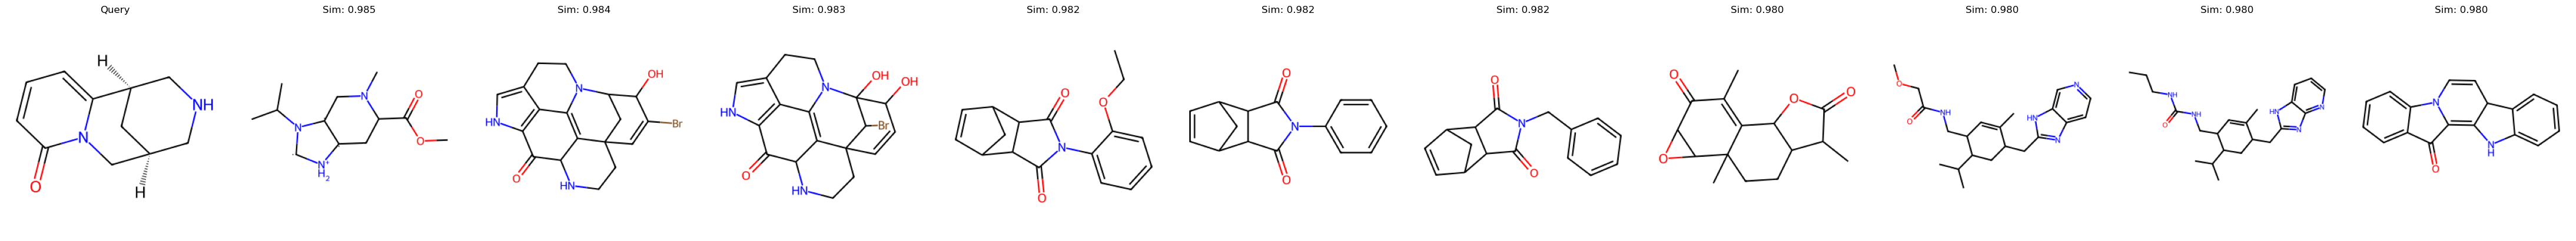

In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import numpy as np

# === 6. Query + Visualization ===
query_smiles = ["O=C1/C=C\\C=C2/N1C[C@@H]3CNC[C@H]2C3"]  # Your query

# Encode & normalize query
query_emb = model.encode(query_smiles, convert_to_numpy=True)
faiss.normalize_L2(query_emb)

k = 10
distances, indices = index.search(query_emb, k)

# Collect molecules and labels
mols = []
labels = []

# Add query molecule (with label "Query")
query_mol = Chem.MolFromSmiles(query_smiles[0])
if query_mol is None:
    print("⚠️ Invalid query SMILES!")
else:
    mols.append(query_mol)
    labels.append("Query")

# Add top-k results
for i in range(k):
    idx = indices[0][i]
    sim_score = distances[0][i]
    smi = smiles_list[idx]
    
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mols.append(mol)
        labels.append(f"Sim: {sim_score:.3f}")
    else:
        print(f"⚠️ Invalid SMILES in result #{i+1}: {smi}")

# Plot
n_mols = len(mols)
if n_mols == 0:
    print("No valid molecules to display.")
else:
    # Create grid: 1 row, n_mols columns
    fig, axes = plt.subplots(1, n_mols, figsize=(4 * n_mols, 4))
    if n_mols == 1:
        axes = [axes]  # make iterable

    # Render each molecule
    for i, (mol, label) in enumerate(zip(mols, labels)):
        img = Draw.MolToImage(mol, size=(300, 300))
        axes[i].imshow(img)
        axes[i].set_title(label, fontsize=12)
        axes[i].axis('off')

    plt.tight_layout()
    
    plt.show()